In [303]:
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [305]:
tweets = pd.read_csv('train.csv')
tweets_test = pd.read_csv('test.csv')

tweets['length']=tweets['text'].str.len()
tweets_test['length']=tweets_test['text'].str.len()

tweets['keyword'] = tweets['keyword'].str.replace('%20', ' ')
tweets['keyword'].fillna('no keyword', inplace = True)

tweets_test['keyword'] = tweets_test['keyword'].str.replace('%20', ' ')
tweets_test['keyword'].fillna('no keyword', inplace = True)

tweets = tweets.sample(frac=1,random_state=1)

In [306]:
tweets['clean_text'] = tweets['text'].str.lower()
tweets_test['clean_text'] = tweets_test['text'].str.lower()

In [307]:
def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

In [308]:
tweets['clean_text'] = tweets['clean_text'].apply(only_letters)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(only_letters)

In [309]:
#Tokenización
from nltk.tokenize import word_tokenize
tweets['clean_text'] = tweets['clean_text'].apply(word_tokenize)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(word_tokenize)
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [310]:
def filter_stopwords(tokenized_text):
    not_stopwords=[]
    for w in tokenized_text:
        if w not in stop_words:
            not_stopwords.append(w)
    return not_stopwords

In [311]:
tweets['clean_text'] = tweets['clean_text'].apply(filter_stopwords)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(filter_stopwords)

In [312]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [313]:
def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

In [314]:
tweets['clean_text'] = tweets['clean_text'].apply(lemmatize_tweet)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lemmatize_tweet)
tweets['clean_text'] = tweets['clean_text'].apply(lambda text:' '.join(text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text:' '.join(text))
tweets['clean_text'] = tweets['clean_text'].apply(lambda text: re.sub(r'amp | im', '', text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text: re.sub(r'amp | im', '', text))

In [315]:
#Nuevos features

In [316]:
def get_hashtags(s):
    return list(part[1:] for part in s.split() if part.startswith('#'))

In [317]:
tweets['hashtags'] = tweets['text'].apply(get_hashtags)
tweets_test['hashtags'] = tweets_test['text'].apply(get_hashtags)

In [318]:
def hashtag_length_proportion(hashtags,length):
    return len(''.join(hashtags))/length

In [319]:
tweets['len_hash_over_text'] = tweets.apply(lambda data: hashtag_length_proportion(data['hashtags'],data['length']),axis=1)
tweets_test['len_hash_over_text'] = tweets_test.apply(lambda data: hashtag_length_proportion(data['hashtags'],data['length']),axis=1)

In [320]:
def get_mentioned_users(s):
    return list(part[1:] for part in s.split() if part.startswith('@'))

In [321]:
tweets['users'] = tweets['text'].apply(get_mentioned_users)
tweets_test['users'] = tweets_test['text'].apply(get_mentioned_users)

In [322]:
def amount_hashtags(l):
    return len(l)

In [323]:
tweets['amount_hashtags']=tweets['hashtags'].apply(amount_hashtags)
tweets_test['amount_hashtags']=tweets_test['hashtags'].apply(amount_hashtags)

In [324]:
def amount_users(l):
    return len(l)

In [325]:
def has_url(text):
    return int('http' in text)

In [326]:
tweets['has_url']=tweets['text'].apply(has_url)
tweets_test['has_url']=tweets_test['text'].apply(has_url)

In [327]:
def find_url(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

In [328]:
tweets['urls']=tweets['text'].apply(find_url)
tweets_test['urls']=tweets_test['text'].apply(find_url)
tweets['amount_urls'] = tweets['urls'].apply(lambda x: len(x))
tweets_test['amount_urls'] = tweets_test['urls'].apply(lambda x: len(x))

In [329]:
tweets['amount_users']=tweets['users'].apply(amount_users)
tweets_test['amount_users']=tweets_test['users'].apply(amount_users)

In [330]:
#Mean encoding keyword
tweets['keyword_encoded'] = tweets.groupby('keyword')['target'].transform('mean')

In [331]:
keywords_dict = pd.Series(tweets['keyword_encoded'].values, index=tweets['keyword']).to_dict()

In [332]:
tweets_test['keyword_encoded']= tweets_test['keyword'].map(keywords_dict)

In [333]:
tweets['len_clean_text_over_text'] = tweets['clean_text'].str.len()/tweets['length']
tweets_test['len_clean_text_over_text'] = tweets_test['clean_text'].str.len()/tweets['length']

In [334]:
tweets.head()

,id,keyword,location,text,target,length,clean_text,hashtags,len_hash_over_text,users,amount_hashtags,has_url,urls,amount_urls,amount_users,keyword_encoded,len_clean_text_over_text
3228,4632,emergency services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1,141,goulburn man henry van bilsen missing emergenc...,[],0.0,[],0,1,[http://t.co/z99pKJzTRp],1,0,0.333333,0.638298
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0,138,thing fear organizationsfluctuations disturban...,[],0.0,[],0,0,[],0,0,0.125000,0.746377
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0,23,tsunamiesh hey esh,[],0.0,[tsunami_esh],0,0,[],0,1,0.323529,0.782609
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0,140,potus drown water entering lung alive caused g...,[],0.0,[POTUS],0,0,[],0,1,0.093750,0.571429
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\r\nThese wounds they will ...,1,51,crawling skin wound hea,[],0.0,[],0,0,[],0,0,0.303030,0.450980


In [335]:
#Me quedo con las columnas numéricas
df = tweets.drop(['text', 'clean_text','location','keyword','hashtags','users','id','urls','target'], axis=1)
df.head()

,length,len_hash_over_text,amount_hashtags,has_url,amount_urls,amount_users,keyword_encoded,len_clean_text_over_text
3228,141,0.0,0,1,1,0,0.333333,0.638298
3706,138,0.0,0,0,0,0,0.125000,0.746377
6957,23,0.0,0,0,0,1,0.323529,0.782609
2887,140,0.0,0,0,0,1,0.093750,0.571429
7464,51,0.0,0,0,0,0,0.303030,0.450980


In [336]:
tweets_dmatrix = xgb.DMatrix(data=df,label=tweets['target'])

In [337]:
df_test = tweets_test.drop(['text', 'clean_text','location','keyword','hashtags','users','id','urls'], axis=1)
df_test.head()

,length,len_hash_over_text,amount_hashtags,has_url,amount_urls,amount_users,keyword_encoded,len_clean_text_over_text
0,34,0.00000,0,0,0,0,0.688525,0.391304
1,64,0.15625,1,0,0,0,0.688525,1.315789
2,96,0.00000,0,0,0,0,0.688525,0.406015
3,40,0.40000,2,0,0,0,0.688525,0.553846
4,45,0.00000,0,0,0,0,0.688525,0.386364


In [338]:
y = tweets['target']

In [339]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20] ,
 "max_depth"        : [ 3, 4, 5, 6, 7],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 0.8 ],
 "n_estimators"     : [ 80, 90, 100, 110]
}

In [340]:
model = xgb.XGBClassifier()

In [341]:
random_search = RandomizedSearchCV(model,param_distributions=params,scoring='f1',cv=5,verbose=3,n_iter=100)

In [342]:
random_search.fit(df,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 
[CV]  n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3, score=0.695, total=   0.1s
[CV] n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3, score=0.702, total=   0.1s
[CV] n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 
[CV]  n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3, score=0.707, total=   0.1s
[CV] n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3, score=0.711, total=   0.1s
[CV] n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 
[CV]  n_estimators=100, min_child_weight=1, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3, score=0.712, total=   0.1s
[CV] n_estimators=90, min_child_weight=3, max_depth=6, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=3, max_depth=6, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7, score=0.701, total=   0.2s
[CV] n_estimators=90, min_child_weight=3, max_depth=6, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=3, max_depth=6, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7, score=0.698, total=   0.2s
[CV] n_estimators=90, min_child_weight=3, max_depth=6, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[CV]  n_estimators=90, m

[CV]  n_estimators=80, min_child_weight=5, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3, score=0.704, total=   0.1s
[CV] n_estimators=80, min_child_weight=5, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3 
[CV]  n_estimators=80, min_child_weight=5, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3, score=0.715, total=   0.1s
[CV] n_estimators=80, min_child_weight=5, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3 
[CV]  n_estimators=80, min_child_weight=5, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.3, score=0.712, total=   0.1s
[CV] n_estimators=100, min_child_weight=1, max_depth=3, learning_rate=0.1, gamma=0.2, colsample_bytree=0.5 
[CV]  n_estimators=100, min_child_weight=1, max_depth=3, learning_rate=0.1, gamma=0.2, colsample_bytree=0.5, score=0.696, total=   0.1s
[CV] n_estimators=100, min_child_weight=1, max_depth=3, learning_rate=0.1, gamma=0.2, colsample_bytree=0.5 
[CV]  n_estimators=100, 

[CV]  n_estimators=100, min_child_weight=7, max_depth=7, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5, score=0.699, total=   0.2s
[CV] n_estimators=100, min_child_weight=7, max_depth=7, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5 
[CV]  n_estimators=100, min_child_weight=7, max_depth=7, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5, score=0.709, total=   0.2s
[CV] n_estimators=100, min_child_weight=7, max_depth=7, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5 
[CV]  n_estimators=100, min_child_weight=7, max_depth=7, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5, score=0.707, total=   0.2s
[CV] n_estimators=100, min_child_weight=7, max_depth=7, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5 
[CV]  n_estimators=100, min_child_weight=7, max_depth=7, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5, score=0.700, total=   0.2s
[CV] n_estimators=110, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.1, colsample_bytree=0.4 
[CV]  n_estimators=110,

[CV]  n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5, score=0.706, total=   0.2s
[CV] n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5 
[CV]  n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5, score=0.710, total=   0.2s
[CV] n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5 
[CV]  n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5, score=0.708, total=   0.2s
[CV] n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5 
[CV]  n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5, score=0.716, total=   0.2s
[CV] n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.5 
[CV]  n_estimators=110, 

[CV]  n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7, score=0.708, total=   0.1s
[CV] n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7, score=0.712, total=   0.1s
[CV] n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7, score=0.699, total=   0.1s
[CV] n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7, score=0.724, total=   0.1s
[CV] n_estimators=90, min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.4, colsample_bytree=0.7 
[CV]  n_estimators=90, m

[CV]  n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7, score=0.704, total=   0.2s
[CV] n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7, score=0.705, total=   0.2s
[CV] n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7, score=0.714, total=   0.2s
[CV] n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7, score=0.715, total=   0.2s
[CV] n_estimators=90, min_child_weight=3, max_depth=5, learning_rate=0.15, gamma=0.3, colsample_bytree=0.7 
[CV]  n_estimators=90, m

[CV]  n_estimators=110, min_child_weight=5, max_depth=6, learning_rate=0.1, gamma=0.4, colsample_bytree=0.3, score=0.707, total=   0.2s
[CV] n_estimators=100, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.4 
[CV]  n_estimators=100, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.4, score=0.695, total=   0.2s
[CV] n_estimators=100, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.4 
[CV]  n_estimators=100, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.4, score=0.704, total=   0.2s
[CV] n_estimators=100, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.4 
[CV]  n_estimators=100, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.4, score=0.700, total=   0.2s
[CV] n_estimators=100, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.4 
[CV]  n_estimators=100, 

[CV]  n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.3, score=0.710, total=   0.1s
[CV] n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.3 
[CV]  n_estimators=110, min_child_weight=5, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.3, score=0.713, total=   0.1s
[CV] n_estimators=100, min_child_weight=5, max_depth=6, learning_rate=0.15, gamma=0.3, colsample_bytree=0.5 
[CV]  n_estimators=100, min_child_weight=5, max_depth=6, learning_rate=0.15, gamma=0.3, colsample_bytree=0.5, score=0.694, total=   0.2s
[CV] n_estimators=100, min_child_weight=5, max_depth=6, learning_rate=0.15, gamma=0.3, colsample_bytree=0.5 
[CV]  n_estimators=100, min_child_weight=5, max_depth=6, learning_rate=0.15, gamma=0.3, colsample_bytree=0.5, score=0.696, total=   0.2s
[CV] n_estimators=100, min_child_weight=5, max_depth=6, learning_rate=0.15, gamma=0.3, colsample_bytree=0.5 
[CV]  n_estimators=

[CV]  n_estimators=100, min_child_weight=7, max_depth=3, learning_rate=0.05, gamma=0.0, colsample_bytree=0.7, score=0.723, total=   0.1s
[CV] n_estimators=100, min_child_weight=7, max_depth=3, learning_rate=0.05, gamma=0.0, colsample_bytree=0.7 
[CV]  n_estimators=100, min_child_weight=7, max_depth=3, learning_rate=0.05, gamma=0.0, colsample_bytree=0.7, score=0.699, total=   0.1s
[CV] n_estimators=100, min_child_weight=3, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=100, min_child_weight=3, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4, score=0.696, total=   0.2s
[CV] n_estimators=100, min_child_weight=3, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=100, min_child_weight=3, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4, score=0.702, total=   0.2s
[CV] n_estimators=100, min_child_weight=3, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=10

[CV]  n_estimators=80, min_child_weight=5, max_depth=6, learning_rate=0.2, gamma=0.3, colsample_bytree=0.5, score=0.715, total=   0.2s
[CV] n_estimators=80, min_child_weight=5, max_depth=6, learning_rate=0.2, gamma=0.3, colsample_bytree=0.5 
[CV]  n_estimators=80, min_child_weight=5, max_depth=6, learning_rate=0.2, gamma=0.3, colsample_bytree=0.5, score=0.700, total=   0.2s
[CV] n_estimators=80, min_child_weight=3, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 
[CV]  n_estimators=80, min_child_weight=3, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3, score=0.704, total=   0.1s
[CV] n_estimators=80, min_child_weight=3, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 
[CV]  n_estimators=80, min_child_weight=3, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3, score=0.707, total=   0.1s
[CV] n_estimators=80, min_child_weight=3, max_depth=5, learning_rate=0.2, gamma=0.2, colsample_bytree=0.3 
[CV]  n_estimators=80, min_child

[CV]  n_estimators=80, min_child_weight=1, max_depth=6, learning_rate=0.1, gamma=0.1, colsample_bytree=0.3, score=0.705, total=   0.1s
[CV] n_estimators=80, min_child_weight=1, max_depth=6, learning_rate=0.1, gamma=0.1, colsample_bytree=0.3 
[CV]  n_estimators=80, min_child_weight=1, max_depth=6, learning_rate=0.1, gamma=0.1, colsample_bytree=0.3, score=0.715, total=   0.1s
[CV] n_estimators=80, min_child_weight=3, max_depth=7, learning_rate=0.05, gamma=0.4, colsample_bytree=0.4 
[CV]  n_estimators=80, min_child_weight=3, max_depth=7, learning_rate=0.05, gamma=0.4, colsample_bytree=0.4, score=0.699, total=   0.2s
[CV] n_estimators=80, min_child_weight=3, max_depth=7, learning_rate=0.05, gamma=0.4, colsample_bytree=0.4 
[CV]  n_estimators=80, min_child_weight=3, max_depth=7, learning_rate=0.05, gamma=0.4, colsample_bytree=0.4, score=0.705, total=   0.2s
[CV] n_estimators=80, min_child_weight=3, max_depth=7, learning_rate=0.05, gamma=0.4, colsample_bytree=0.4 
[CV]  n_estimators=80, min_

[CV]  n_estimators=80, min_child_weight=7, max_depth=7, learning_rate=0.05, gamma=0.2, colsample_bytree=0.7, score=0.707, total=   0.2s
[CV] n_estimators=80, min_child_weight=7, max_depth=7, learning_rate=0.05, gamma=0.2, colsample_bytree=0.7 
[CV]  n_estimators=80, min_child_weight=7, max_depth=7, learning_rate=0.05, gamma=0.2, colsample_bytree=0.7, score=0.731, total=   0.2s
[CV] n_estimators=80, min_child_weight=7, max_depth=7, learning_rate=0.05, gamma=0.2, colsample_bytree=0.7 
[CV]  n_estimators=80, min_child_weight=7, max_depth=7, learning_rate=0.05, gamma=0.2, colsample_bytree=0.7, score=0.692, total=   0.2s
[CV] n_estimators=110, min_child_weight=1, max_depth=7, learning_rate=0.15, gamma=0.4, colsample_bytree=0.4 
[CV]  n_estimators=110, min_child_weight=1, max_depth=7, learning_rate=0.15, gamma=0.4, colsample_bytree=0.4, score=0.691, total=   0.2s
[CV] n_estimators=110, min_child_weight=1, max_depth=7, learning_rate=0.15, gamma=0.4, colsample_bytree=0.4 
[CV]  n_estimators=11

[CV]  n_estimators=90, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=0.4, colsample_bytree=0.7, score=0.709, total=   0.2s
[CV] n_estimators=90, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=0.4, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=0.4, colsample_bytree=0.7, score=0.703, total=   0.2s
[CV] n_estimators=90, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=0.4, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=0.4, colsample_bytree=0.7, score=0.723, total=   0.2s
[CV] n_estimators=90, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=0.4, colsample_bytree=0.7 
[CV]  n_estimators=90, min_child_weight=5, max_depth=5, learning_rate=0.1, gamma=0.4, colsample_bytree=0.7, score=0.713, total=   0.2s
[CV] n_estimators=110, min_child_weight=5, max_depth=3, learning_rate=0.15, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=110, min_ch

[CV]  n_estimators=80, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=0.5, score=0.716, total=   0.1s
[CV] n_estimators=80, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=0.5 
[CV]  n_estimators=80, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=0.5, score=0.699, total=   0.1s
[CV] n_estimators=80, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=0.5 
[CV]  n_estimators=80, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=0.5, score=0.721, total=   0.1s
[CV] n_estimators=80, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=0.5 
[CV]  n_estimators=80, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=0.5, score=0.706, total=   0.1s
[CV] n_estimators=100, min_child_weight=3, max_depth=3, learning_rate=0.2, gamma=0.2, colsample_bytree=0.5 
[CV]  n_estimators=100, min_chi

[CV] n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4, score=0.706, total=   0.2s
[CV] n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4, score=0.712, total=   0.2s
[CV] n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4, score=0.702, total=   0.2s
[CV] n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4 
[CV]  n_estimators=90, min_child_weight=7, max_depth=6, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4, score=0.718, total=   0.2s
[CV] n_estimators=90, min_child_

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.7,
                                  

In [343]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [344]:
random_search.best_params_

{'n_estimators': 80,
 'min_child_weight': 7,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [345]:
model = random_search.best_estimator_

In [346]:
#Predicciones set de train
preds = model.predict(data=df)

In [347]:
f1score = f1_score(tweets['target'], preds)
print(f'Counts model score: {f1score*100}%')

Counts model score: 73.86052504429055%


In [353]:
rmse = np.sqrt(mean_squared_error(tweets['target'], preds))
print(f'RMSE: %f' % (rmse))

RMSE: 0.461723


In [348]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(tweets['target'], preds))

[[3697  645]
 [ 978 2293]]


In [349]:
#Predicciones set de test
preds_test = model.predict(data=df_test)
preds_test

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [350]:
tweets_test['target'] = preds_test.astype(int)
submission = tweets_test.loc[:,['id','target']]

In [351]:
submission.to_csv(path_or_buf='submissionxgb.csv',header=True,index=False)

Feature importance

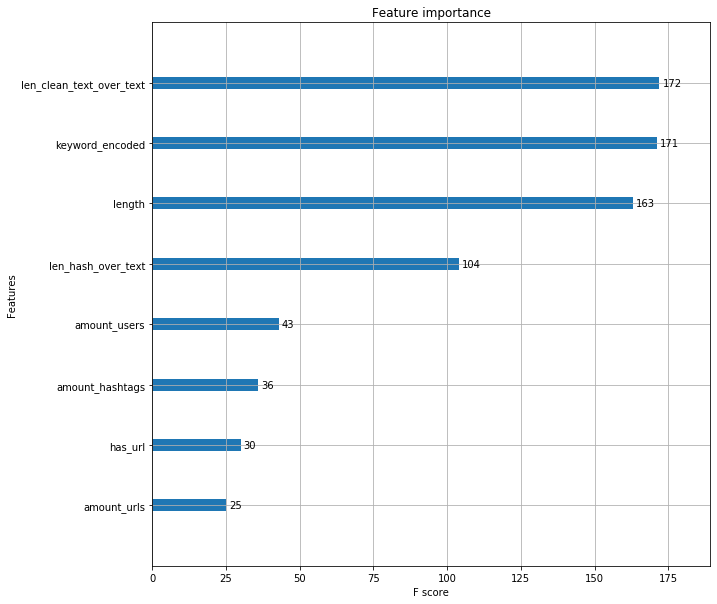

In [352]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, max_num_features=10, ax=ax)